# Times Series with GARCH

In [33]:
from arch import arch_model
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
plt.style.use("seaborn")
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf
import datetime as dt
import glob
import cufflinks as cf
cf.set_config_file(offline = True)
%matplotlib inline
import scipy
import scipy.stats as stats

# Extracting Data from Google Finance
## Step 1
1. Four indices to look at to predict market volatility 
2. preparing out data to be fitted into our model


In [5]:
#Path
Path =  "C:\\Users\\eszczepalink\\Downloads\\Indices/"

In [6]:
# use glob to read csvs
glob.glob(Path+ "/*.csv")

['C:\\Users\\eszczepalink\\Downloads\\Indices\\DJI - Sheet1.csv',
 'C:\\Users\\eszczepalink\\Downloads\\Indices\\INX - Sheet1.csv',
 'C:\\Users\\eszczepalink\\Downloads\\Indices\\IXIC - Sheet1.csv',
 'C:\\Users\\eszczepalink\\Downloads\\Indices\\RUT 2k - Sheet1.csv',
 'C:\\Users\\eszczepalink\\Downloads\\Indices\\RUT 3K - Sheet1.csv']

In [7]:
# Import data and rename Close columns
DJI_DF = pd.read_csv(Path+"DJI - Sheet1.csv", 
            parse_dates = ["Date"],
           index_col = "Date").rename(columns={"Close":"DJI_Close"})
SP_DF = pd.read_csv(Path+"INX - Sheet1.csv",
            parse_dates = ["Date"],
            index_col= "Date").rename(columns={"Close":"SP_Close"})
NQ_DF = pd.read_csv(Path+"IXIC - Sheet1.csv",
            parse_dates = ["Date"],
            index_col = "Date").rename(columns={"Close":"NQ_Close"})
RUT2K = pd.read_csv(Path+"RUT 2k - Sheet1.csv",
            parse_dates= ["Date"],
            index_col= "Date").rename(columns={"Close":"RUT2K_Close"})
RUT3K = pd.read_csv(Path+"RUT 3k - Sheet1.csv",
            parse_dates= ["Date"],
            index_col= "Date").rename(columns={"Close":"RUT3K_Close"})


In [8]:
# Concatenating DF's into volatility df
volatility_df = pd.concat([DJI_DF,SP_DF,NQ_DF,RUT2K,RUT3K], axis=1)

In [9]:
# check info
volatility_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3030 entries, 2010-09-28 16:00:00 to 2022-09-23 16:00:00
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DJI_Close    3012 non-null   float64
 1   SP_Close     3026 non-null   float64
 2   NQ_Close     3019 non-null   float64
 3   RUT2K_Close  3010 non-null   float64
 4   RUT3K_Close  3010 non-null   float64
dtypes: float64(5)
memory usage: 142.0 KB


In [10]:
# check missing value 
volatility_df.isna().sum()

DJI_Close      18
SP_Close        4
NQ_Close       11
RUT2K_Close    20
RUT3K_Close    20
dtype: int64

In [11]:
# display whole DataFrame
volatility_df

,DJI_Close,SP_Close,NQ_Close,RUT2K_Close,RUT3K_Close
Date,,,,,
2010-09-28 16:00:00,10858.14,1147.70,2379.59,675.43,675.43
2010-09-29 16:00:00,10835.28,1144.73,2376.56,677.64,677.64
2010-09-30 16:00:00,10788.05,1141.20,2368.62,676.14,676.14
2010-10-01 16:00:00,10829.70,1146.24,2370.75,679.29,679.29
2010-10-04 16:00:00,10751.27,1137.03,2344.52,669.45,669.45
...,...,...,...,...,...
2022-09-19 16:00:00,31019.68,3899.89,11535.02,1812.84,1812.84
2022-09-20 16:00:00,30706.23,3855.93,11425.05,1787.50,1787.50
2022-09-21 16:00:00,30183.78,3789.93,11220.19,1762.16,1762.16


In [12]:
# using front fill DIJ_Close
volatility_df.DJI_Close = volatility_df.DJI_Close.fillna(method="ffill")

In [13]:
# check is null
volatility_df.isna().sum()

DJI_Close       0
SP_Close        4
NQ_Close       11
RUT2K_Close    20
RUT3K_Close    20
dtype: int64

In [14]:
# using front fill DIJ_Close
volatility_df.SP_Close = volatility_df.SP_Close.fillna(method="ffill")

In [15]:
# check is null
volatility_df.isna().sum()

DJI_Close       0
SP_Close        0
NQ_Close       11
RUT2K_Close    20
RUT3K_Close    20
dtype: int64

In [16]:
# using back fill to fill the rest of na's
volatility_df = volatility_df.fillna(method="bfill")

In [17]:
# check is null
volatility_df.isna().sum()

DJI_Close      0
SP_Close       0
NQ_Close       0
RUT2K_Close    0
RUT3K_Close    0
dtype: int64

In [18]:
# save dataframe to new csv called update
volatility_df.to_csv("volatility_df_update.csv")

In [19]:
# read our new data fron saved csv
df_indices = pd.read_csv("volatility_df_update.csv",
                        parse_dates=True,
                        infer_datetime_format=True,
                        index_col="Date")

In [20]:
df_indices

,DJI_Close,SP_Close,NQ_Close,RUT2K_Close,RUT3K_Close
Date,,,,,
2010-09-28 16:00:00,10858.14,1147.70,2379.59,675.43,675.43
2010-09-29 16:00:00,10835.28,1144.73,2376.56,677.64,677.64
2010-09-30 16:00:00,10788.05,1141.20,2368.62,676.14,676.14
2010-10-01 16:00:00,10829.70,1146.24,2370.75,679.29,679.29
2010-10-04 16:00:00,10751.27,1137.03,2344.52,669.45,669.45
...,...,...,...,...,...
2022-09-19 16:00:00,31019.68,3899.89,11535.02,1812.84,1812.84
2022-09-20 16:00:00,30706.23,3855.93,11425.05,1787.50,1787.50
2022-09-21 16:00:00,30183.78,3789.93,11220.19,1762.16,1762.16


<AxesSubplot:ylabel='Density'>

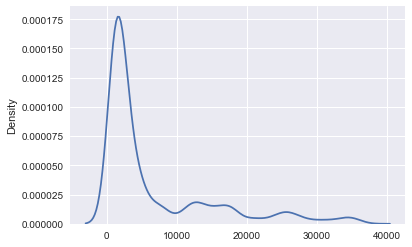

In [21]:
# display density of our data
sns.distplot(df_indices, hist=False, kde=True)

<AxesSubplot:title={'center':'DJI_Close/SP_Close/NQ_Close/RUT2K_Close/RUT3K_Close'}, xlabel='Date'>

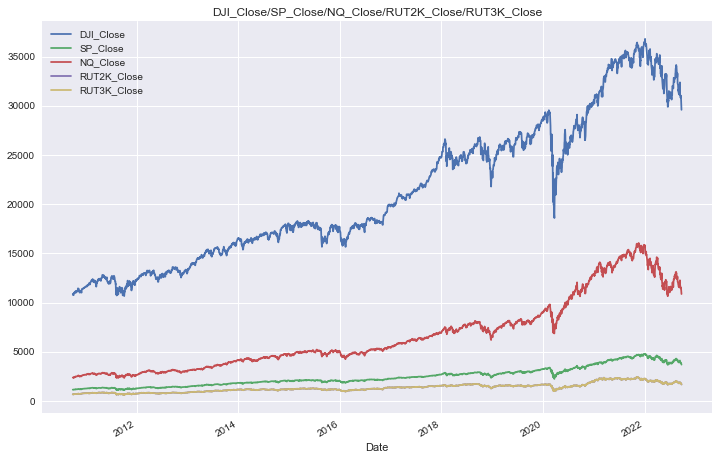

In [22]:
df_indices.plot(figsize=(12, 8), title="DJI_Close/SP_Close/NQ_Close/RUT2K_Close/RUT3K_Close")

In [23]:
# Creating Daily Return
df_indices["Return_DJI"] = df_indices["DJI_Close"].pct_change()
df_indices["Return_SP"] = df_indices["SP_Close"].pct_change()
df_indices["Return_NQ"] = df_indices["NQ_Close"].pct_change()
df_indices["Return_RUT2K"] = df_indices["RUT2K_Close"].pct_change()
df_indices["Return_RUT3K"] = df_indices["RUT3K_Close"].pct_change()

In [24]:
# new data frame with pct_change
df_indices

,DJI_Close,SP_Close,NQ_Close,RUT2K_Close,RUT3K_Close,Return_DJI,Return_SP,Return_NQ,Return_RUT2K,Return_RUT3K
Date,,,,,,,,,,
2010-09-28 16:00:00,10858.14,1147.70,2379.59,675.43,675.43,NaN,NaN,NaN,NaN,NaN
2010-09-29 16:00:00,10835.28,1144.73,2376.56,677.64,677.64,-0.002105,-0.002588,-0.001273,0.003272,0.003272
2010-09-30 16:00:00,10788.05,1141.20,2368.62,676.14,676.14,-0.004359,-0.003084,-0.003341,-0.002214,-0.002214
2010-10-01 16:00:00,10829.70,1146.24,2370.75,679.29,679.29,0.003861,0.004416,0.000899,0.004659,0.004659
2010-10-04 16:00:00,10751.27,1137.03,2344.52,669.45,669.45,-0.007242,-0.008035,-0.011064,-0.014486,-0.014486
...,...,...,...,...,...,...,...,...,...,...
2022-09-19 16:00:00,31019.68,3899.89,11535.02,1812.84,1812.84,0.006400,0.006857,0.007566,0.008147,0.008147
2022-09-20 16:00:00,30706.23,3855.93,11425.05,1787.50,1787.50,-0.010105,-0.011272,-0.009534,-0.013978,-0.013978
2022-09-21 16:00:00,30183.78,3789.93,11220.19,1762.16,1762.16,-0.017014,-0.017116,-0.017931,-0.014176,-0.014176


In [25]:
# dropna's
df_indices.dropna(inplace=True)

<AxesSubplot:ylabel='Density'>

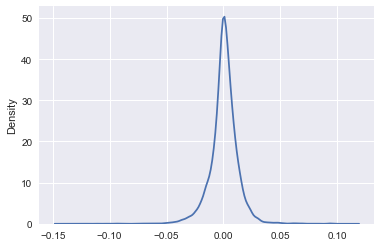

In [26]:
# display returns
sns.distplot(df_indices[['Return_DJI','Return_SP','Return_NQ','Return_RUT2K','Return_RUT3K']], 
                             hist=False, kde=True)

In [28]:
# Calculating rolling std for 5-day window
df_indices["std_DJI"] = df_indices["Return_DJI"].rolling(window=5).std()
df_indices["std_SP"] = df_indices["Return_SP"].rolling(window=5).std()
df_indices["std_NQ"] = df_indices["Return_NQ"].rolling(window=5).std()
df_indices["std_RUT2K"] = df_indices["Return_RUT2K"].rolling(window=5).std()
df_indices["std_RUT3K"] = df_indices["Return_RUT3K"].rolling(window=5).std()

In [29]:
# Drop na's
volatility_df.dropna(inplace=True)

In [31]:
# data frame
display(df_indices.head(2))
display(df_indices.tail(2))

,DJI_Close,SP_Close,NQ_Close,RUT2K_Close,RUT3K_Close,Return_DJI,Return_SP,Return_NQ,Return_RUT2K,Return_RUT3K,std_DJI,std_SP,std_NQ,std_RUT2K,std_RUT3K
Date,,,,,,,,,,,,,,,
2010-09-29 16:00:00,10835.28,1144.73,2376.56,677.64,677.64,-0.002105,-0.002588,-0.001273,0.003272,0.003272,NaN,NaN,NaN,NaN,NaN
2010-09-30 16:00:00,10788.05,1141.20,2368.62,676.14,676.14,-0.004359,-0.003084,-0.003341,-0.002214,-0.002214,NaN,NaN,NaN,NaN,NaN


,DJI_Close,SP_Close,NQ_Close,RUT2K_Close,RUT3K_Close,Return_DJI,Return_SP,Return_NQ,Return_RUT2K,Return_RUT3K,std_DJI,std_SP,std_NQ,std_RUT2K,std_RUT3K
Date,,,,,,,,,,,,,,,
2022-09-22 16:00:00,30076.68,3757.99,11066.81,1722.31,1722.31,-0.003548,-0.008428,-0.013670,-0.022614,-0.022614,0.008658,0.008857,0.009684,0.011552,0.011552
2022-09-23 16:00:00,29590.41,3693.23,10867.93,1679.59,1679.59,-0.016168,-0.017233,-0.017971,-0.024804,-0.024804,0.009741,0.009870,0.010586,0.013040,0.013040


In [32]:
# plot volatility of indices
df_indices[["std_DJI","std_SP","std_NQ","std_RUT2K","std_RUT3K"]].iplot(title="Volatility indices",
                                                                           xTitle="Time",
                                                                           yTitle="volatility",
                                                                           theme= "solar")

# Step 2
1. Check for Stationarity 
2. A Stationary time series is one whose mean and vatiance does not change over time
3. perform augmentation testing Dickey-Fuller Test (ADF Test) 

In [38]:
df = df_indices[['Return_DJI','Return_SP','Return_NQ','Return_RUT2K','Return_RUT3K']]

In [50]:
df_indices[['Return_DJI','Return_SP','Return_NQ','Return_RUT2K','Return_RUT3K']].iplot(title="Volatility indices",
                                                                           xTitle="Time",
                                                                           yTitle="volatility",
                                                                           theme= "solar")

In [47]:
adfuller(df['Return_DJI'])

(-11.687404455572,
 1.6841952804861076e-21,
 27,
 3001,
 {'1%': -3.432530907127241,
  '5%': -2.862503583908354,
  '10%': -2.5672829410267664},
 -18827.90291943291)

In [130]:
adfuller(df['Return_SP'])

(-6.911677619710269,
 1.207904151528661e-09,
 5,
 675,
 {'1%': -3.4400749518321394,
  '5%': -2.865831348847229,
  '10%': -2.5690552762688617},
 1228.0550833852033)

In [131]:
adfuller(df['Return_NQ'])

(-6.111898749876844,
 9.289629981659776e-08,
 7,
 673,
 {'1%': -3.4401039634870623,
  '5%': -2.8658441302164346,
  '10%': -2.569062085956077},
 -4520.969529960705)

In [132]:
adfuller(df['Return_RUT2K'])

(-6.086112438211301,
 1.0634381334260311e-07,
 6,
 674,
 {'1%': -3.4400894360545475,
  '5%': -2.865837730028723,
  '10%': -2.5690586760471605},
 -4295.071248268361)

In [133]:
adfuller(df['Return_RUT3K'])

(-6.086112438211301,
 1.0634381334260311e-07,
 6,
 674,
 {'1%': -3.4400894360545475,
  '5%': -2.865837730028723,
  '10%': -2.5690586760471605},
 -4295.071248268361)

In [ ]:
#Test statistic: -11.68
# P-value: 1.68 e-21 since p-value less than 0.5, we rject the null hypothesis 
# this means the time series is stationary

# Calculate volatility for DJI

In [172]:
# Calculate daily std of returns
std_daily = df['Return_DJI'].std()
print(f'Daily volatility: {round(std_daily,2)}%')

# Convert daily volatility to monthly volatility
std_monthly = np.sqrt(21) * std_daily
print(f'\nMonthly volatility: {round(std_monthly,2)}%')

# Convert daily volatility to annaul volatility
std_annual = np.sqrt(252) * std_daily

print(f'\nAnnual volatility: {round(std_annual,2)}%')

Daily volatility: 0.56%

Monthly volatility: 2.58%

Annual volatility: 8.93%


## Fit a Garch model ()  since we assumed our data is stationary
## p = ?, q = ?

In [ ]:
# it's mathematically proven no higher order Garch models outperform the GARCH(1,1)
# when it comes to variance of market returns
# all you need to know that higher order Garch model isn't necessary


In [138]:
test_results = {}

for p in range(3):
    for q in range(3):
        if p == 0 and q == 0:
            continue
            
        print(f'Testing Order: p = {p}, q = {q}')
      
        
        try:
            model = arch_model(df,p=p,q=q, vol="GARCH")
            model_result = model.fit()
    
                
        except ValueError:
            stationarity_error += 1
                
       


Testing Order: p = 0, q = 1
Testing Order: p = 0, q = 2
Testing Order: p = 1, q = 0
Testing Order: p = 1, q = 1
Testing Order: p = 1, q = 2
Testing Order: p = 2, q = 0
Testing Order: p = 2, q = 1
Testing Order: p = 2, q = 2


# Resample data by weakly return to get futher forcasting 

In [146]:
df = df.resample('W').mean()

In [158]:
df.isnull().sum()

Return_DJI      230
Return_SP       230
Return_NQ       230
Return_RUT2K    230
Return_RUT3K    230
dtype: int64

In [159]:
df.fillna(0,inplace=True)

# Implement a basic GARCH model
1. to implement a GARCH(1,1) model, First defines basic GRACH(1,1) model, then fit model, review the model fitting summary and plot the results

In [ ]:
# it's mathematically proven no higher order Garch models outperform the GARCH(1,1)
# when it comes to variance of market returns
# all you need to know that higher order Garch model isn't necessary
# this model it took 11 iterations to converge 

In [160]:
df.columns

Index(['Return_DJI', 'Return_SP', 'Return_NQ', 'Return_RUT2K', 'Return_RUT3K'], dtype='object')

Iteration:      1,   Func. Count:      6,   Neg. LLF: 8464.973057674424
Iteration:      2,   Func. Count:     15,   Neg. LLF: 2630.754901494126
Iteration:      3,   Func. Count:     24,   Neg. LLF: 1376.6517353635688
Iteration:      4,   Func. Count:     30,   Neg. LLF: 482.68746304736703
Iteration:      5,   Func. Count:     36,   Neg. LLF: 732.2844767425945
Iteration:      6,   Func. Count:     42,   Neg. LLF: 487.8712626777225
Iteration:      7,   Func. Count:     48,   Neg. LLF: 479.7952379876595
Iteration:      8,   Func. Count:     53,   Neg. LLF: 479.79462428878037
Iteration:      9,   Func. Count:     58,   Neg. LLF: 479.7941053304443
Iteration:     10,   Func. Count:     63,   Neg. LLF: 479.794092345003
Iteration:     11,   Func. Count:     67,   Neg. LLF: 479.79409234584574
Optimization terminated successfully    (Exit mode 0)
            Current function value: 479.794092345003
            Iterations: 11
            Function evaluations: 67
            Gradient evaluations: 

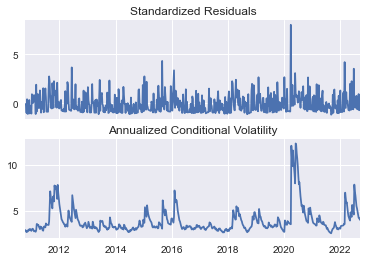

In [161]:
# Specify GARCH model assumptions
model_garch_DJI = arch_model(df['Return_DJI'], p = 1, q = 1,
                      mean = 'constant', vol = 'GARCH', dist = 'normal')
# Fit the model                  freq to avoid display unnecessary value
result_DJI = model_garch_DJI.fit(update_freq = 5)


# Display model fitting summary
print(result_DJI.summary())


# Plot fitted results
result_DJI.plot(annualize='W')
plt.show()


# Make forecast with GARCH models

In [162]:
df.index.max()


Timestamp('2022-09-18 00:00:00', freq='W-SUN')

In [167]:
# horizon = how many observations we want our model to predict for each day 
# for each date, we'll get the predicted value, for the next date
pred_grach = result_DJI.forecast(start = "2022-09-18",horizon= 5)
# prediction value for next week
print(pred_grach.variance[-1:])

                 h.1      h.2       h.3      h.4       h.5
Date                                                      
2022-09-18  0.281591  0.28861  0.295232  0.30148  0.307373


# Distribution assumptions
1. Volatility is not directly observed
2. GARCH model use residuals as volatilty shocks
3. Volatility is related to the residuals
### Residual = predicted return - mean return
  1. Residual = predicted return - mean return
 
  2. Standardized residual = residual / return volatility


# Plot distribution of standardized residuals

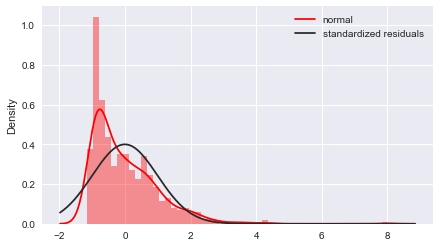

In [168]:
# Obtain model estimated residuals and volatility
model_DJI_resid = result_DJI.resid
model_DJI_std = result_DJI.conditional_volatility

# Calculate the standardized residuals
model_std_resid = model_DJI_resid /model_DJI_std

# Plot the histogram of the standardized residuals
plt.figure(figsize=(7,4))
sns.distplot(model_std_resid, norm_hist=True, fit=stats.norm, bins=50, color='r')
plt.legend(('normal', 'standardized residuals'))
plt.show()

# Fit a GARCH with skewed t-distribution